In [130]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer,word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from trim import process
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
nltk.download('stopwords')
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from list import flat_list,to_list 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tanve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [131]:
df=pd.read_csv('mtsamples.csv')

In [132]:
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [133]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [134]:
df=process(df)

In [135]:
df['medical_specialty'].value_counts()

Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

In [136]:
df=df[df['medical_specialty'].isin(['Cardiovascular / Pulmonary ','Neurosurgery','ENT - Otolaryngology','Discharge Summary','Orthopedic','Gastroenterology'])]

In [137]:
df.head()

,description,medical_specialty,sample_name,transcription,keywords
2008,Youngswick osteotomy with internal screw fixat...,Orthopedic,Youngswick Osteotomy,"TITLE OF OPERATION: , Youngswick osteotomy wit...","orthopedic, hallux limitus deformity, metatars..."
2011,Austin & Youngswick bunionectomy with Biopro i...,Orthopedic,Youngswick Bunionectomy,"PREOPERATIVE DIAGNOSES:,1. Hallux rigidus, le...","orthopedic, hallux rigidus, metatarsal, youngs..."
2012,Consultation for wrist pain.,Orthopedic,Wrist Pain,"CHIEF COMPLAINT:, Left wrist pain.,HISTORY OF...","orthopedic, wrist pain, scapholunate, tenderne..."
2013,Excision of dorsal wrist ganglion. Made a tra...,Orthopedic,Wrist Ganglion Excision,"PREOPERATIVE DIAGNOSIS: , Wrist ganglion.,POST...","orthopedic, origin of stalk, extensor retinacu..."
2014,Unilateral transpedicular T11 vertebroplasty.,Orthopedic,Vertebroplasty,"PREOPERATIVE DIAGNOSIS:, T11 compression frac...","orthopedic, transpedicular, vertebroplasty, fl..."


In [138]:
word_count_df = df.groupby('medical_specialty')['transcription'].apply(lambda x: x.str.split().str.len().sum()).reset_index()
word_count_df.columns = ['Medical Specialty', 'Word Count']
word_count_df['Word Count'] = word_count_df['Word Count'].astype(int)
word_count_df = word_count_df.sort_values('Word Count', ascending=False).reset_index(drop=True)


In [139]:
word_count_df

,Medical Specialty,Word Count
0,Orthopedic,198489
1,Gastroenterology,80347
2,Neurosurgery,54233
3,Discharge Summary,43103
4,ENT - Otolaryngology,42032


In [140]:
df.isnull().sum()

description            0
medical_specialty      0
sample_name            0
transcription          8
keywords             137
dtype: int64

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885 entries, 2008 to 3994
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        885 non-null    object
 1   medical_specialty  885 non-null    object
 2   sample_name        885 non-null    object
 3   transcription      877 non-null    object
 4   keywords           748 non-null    object
dtypes: object(5)
memory usage: 41.5+ KB


In [142]:
df=df[df['transcription'].notna()]

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877 entries, 2008 to 3994
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        877 non-null    object
 1   medical_specialty  877 non-null    object
 2   sample_name        877 non-null    object
 3   transcription      877 non-null    object
 4   keywords           740 non-null    object
dtypes: object(5)
memory usage: 41.1+ KB


In [144]:
df=df[['medical_specialty','transcription']]

In [145]:
df.head()

,medical_specialty,transcription
2008,Orthopedic,"TITLE OF OPERATION: , Youngswick osteotomy wit..."
2011,Orthopedic,"PREOPERATIVE DIAGNOSES:,1. Hallux rigidus, le..."
2012,Orthopedic,"CHIEF COMPLAINT:, Left wrist pain.,HISTORY OF..."
2013,Orthopedic,"PREOPERATIVE DIAGNOSIS: , Wrist ganglion.,POST..."
2014,Orthopedic,"PREOPERATIVE DIAGNOSIS:, T11 compression frac..."


In [146]:
df['transcription'] = df['transcription'].apply(lambda x : str.lower(x))

In [147]:
df.head()

,medical_specialty,transcription
2008,Orthopedic,"title of operation: , youngswick osteotomy wit..."
2011,Orthopedic,"preoperative diagnoses:,1. hallux rigidus, le..."
2012,Orthopedic,"chief complaint:, left wrist pain.,history of..."
2013,Orthopedic,"preoperative diagnosis: , wrist ganglion.,post..."
2014,Orthopedic,"preoperative diagnosis:, t11 compression frac..."


In [148]:
df['transcription'] = df['transcription'].apply(lambda x: re.sub(r'\d+', '', " ".join(re.findall(r'\w+', x))))


In [149]:
df.head()

,medical_specialty,transcription
2008,Orthopedic,title of operation youngswick osteotomy with i...
2011,Orthopedic,preoperative diagnoses hallux rigidus left fo...
2012,Orthopedic,chief complaint left wrist pain history of pre...
2013,Orthopedic,preoperative diagnosis wrist ganglion postoper...
2014,Orthopedic,preoperative diagnosis t compression fracture ...


In [150]:
df['tokenized_text'] = df['transcription'].apply(word_tokenize)

In [151]:
df.head()

,medical_specialty,transcription,tokenized_text
2008,Orthopedic,title of operation youngswick osteotomy with i...,"[title, of, operation, youngswick, osteotomy, ..."
2011,Orthopedic,preoperative diagnoses hallux rigidus left fo...,"[preoperative, diagnoses, hallux, rigidus, lef..."
2012,Orthopedic,chief complaint left wrist pain history of pre...,"[chief, complaint, left, wrist, pain, history,..."
2013,Orthopedic,preoperative diagnosis wrist ganglion postoper...,"[preoperative, diagnosis, wrist, ganglion, pos..."
2014,Orthopedic,preoperative diagnosis t compression fracture ...,"[preoperative, diagnosis, t, compression, frac..."


In [152]:
stemmer=PorterStemmer()
df['stemmed_text'] = df['tokenized_text'].apply(lambda x:[stemmer.stem(y) for y in x])

In [153]:
df.head()

,medical_specialty,transcription,tokenized_text,stemmed_text
2008,Orthopedic,title of operation youngswick osteotomy with i...,"[title, of, operation, youngswick, osteotomy, ...","[titl, of, oper, youngswick, osteotomi, with, ..."
2011,Orthopedic,preoperative diagnoses hallux rigidus left fo...,"[preoperative, diagnoses, hallux, rigidus, lef...","[preoper, diagnos, hallux, rigidu, left, foot,..."
2012,Orthopedic,chief complaint left wrist pain history of pre...,"[chief, complaint, left, wrist, pain, history,...","[chief, complaint, left, wrist, pain, histori,..."
2013,Orthopedic,preoperative diagnosis wrist ganglion postoper...,"[preoperative, diagnosis, wrist, ganglion, pos...","[preoper, diagnosi, wrist, ganglion, postop, d..."
2014,Orthopedic,preoperative diagnosis t compression fracture ...,"[preoperative, diagnosis, t, compression, frac...","[preoper, diagnosi, t, compress, fractur, with..."


In [154]:
stop=stopwords.words('english')
df['removed_stopwords']=df['stemmed_text'].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))

In [155]:
df.head()

,medical_specialty,transcription,tokenized_text,stemmed_text,removed_stopwords
2008,Orthopedic,title of operation youngswick osteotomy with i...,"[title, of, operation, youngswick, osteotomy, ...","[titl, of, oper, youngswick, osteotomi, with, ...",titl oper youngswick osteotomi intern screw fi...
2011,Orthopedic,preoperative diagnoses hallux rigidus left fo...,"[preoperative, diagnoses, hallux, rigidus, lef...","[preoper, diagnos, hallux, rigidu, left, foot,...",preoper diagnos hallux rigidu left foot elev f...
2012,Orthopedic,chief complaint left wrist pain history of pre...,"[chief, complaint, left, wrist, pain, history,...","[chief, complaint, left, wrist, pain, histori,...",chief complaint left wrist pain histori presen...
2013,Orthopedic,preoperative diagnosis wrist ganglion postoper...,"[preoperative, diagnosis, wrist, ganglion, pos...","[preoper, diagnosi, wrist, ganglion, postop, d...",preoper diagnosi wrist ganglion postop diagnos...
2014,Orthopedic,preoperative diagnosis t compression fracture ...,"[preoperative, diagnosis, t, compression, frac...","[preoper, diagnosi, t, compress, fractur, with...",preoper diagnosi compress fractur intract pain...


In [156]:
df=df[['medical_specialty','removed_stopwords']]

In [157]:
df.head()

,medical_specialty,removed_stopwords
2008,Orthopedic,titl oper youngswick osteotomi intern screw fi...
2011,Orthopedic,preoper diagnos hallux rigidu left foot elev f...
2012,Orthopedic,chief complaint left wrist pain histori presen...
2013,Orthopedic,preoper diagnosi wrist ganglion postop diagnos...
2014,Orthopedic,preoper diagnosi compress fractur intract pain...


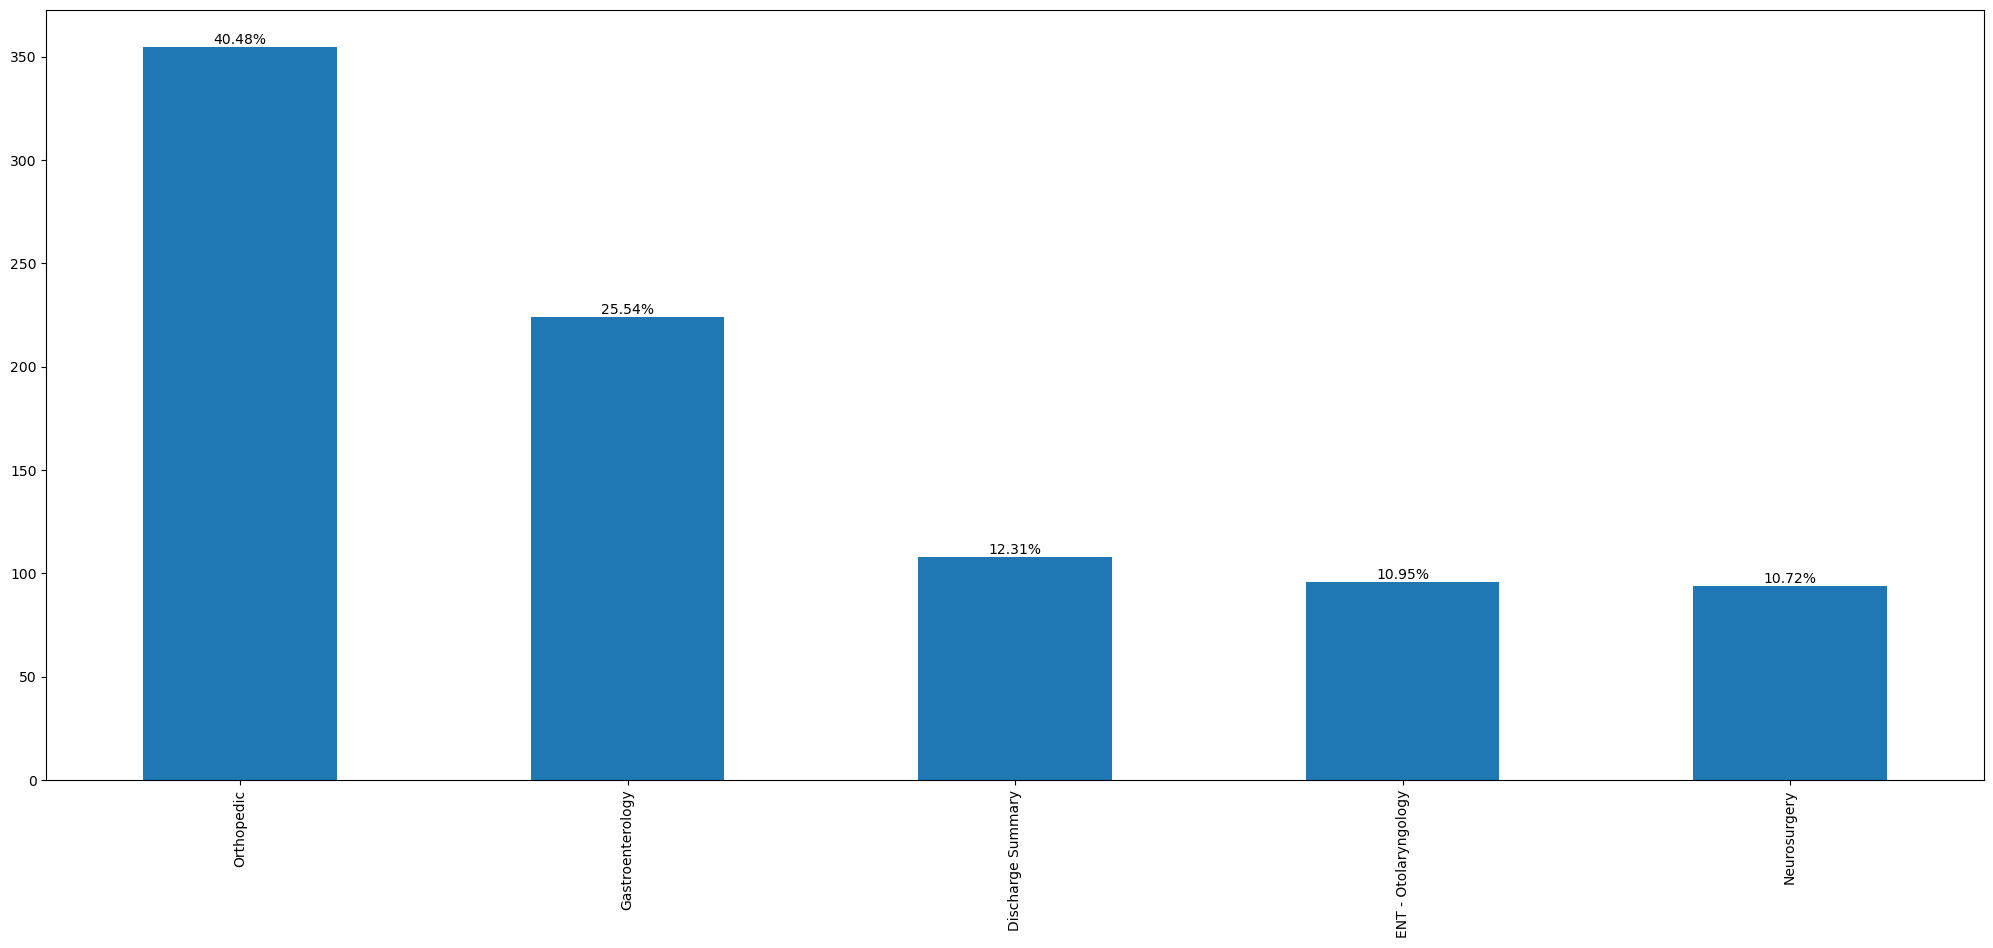

In [158]:
label_counts = df['medical_specialty'].value_counts()
plt.figure(figsize=(25, 10))
label_counts.plot(kind='bar')
total = label_counts.sum()
percentages = (label_counts / total) * 100
for i, value in enumerate(label_counts):
    plt.text(i, value, f"{percentages[i]:.2f}%", ha='center', va='bottom')
plt.show()

In [159]:
le = LabelEncoder()
le.fit(df['medical_specialty'])
df['encoded_target'] = le.transform(df['medical_specialty'])
df.head()
dictionary=df.set_index('medical_specialty')['encoded_target'].to_dict()

In [160]:
df.head()

,medical_specialty,removed_stopwords,encoded_target
2008,Orthopedic,titl oper youngswick osteotomi intern screw fi...,4
2011,Orthopedic,preoper diagnos hallux rigidu left foot elev f...,4
2012,Orthopedic,chief complaint left wrist pain histori presen...,4
2013,Orthopedic,preoper diagnosi wrist ganglion postop diagnos...,4
2014,Orthopedic,preoper diagnosi compress fractur intract pain...,4


In [161]:
dictionary

{'Orthopedic': 4,
 'Neurosurgery': 3,
 'Gastroenterology': 2,
 'ENT - Otolaryngology': 1,
 'Discharge Summary': 0}

In [162]:
flat_list_transcription = to_list(df, 'removed_stopwords')

In [163]:
vectorizer = CountVectorizer(ngram_range=(1,1))
vectorizer.fit(flat_list_transcription)
temp=[(vectorizer.transform(flat_list_transcription))]


In [164]:
dataframes = {'unigram':temp[0]}
feature_vector = [] ; feature_vector_shape = []
for key in dataframes:
    feature_vector.append(key)
    feature_vector_shape.append(dataframes[key].shape)

n_gram_df = pd.DataFrame({'N-gram':feature_vector, 'Data Dimension':feature_vector_shape})
n_gram_df

,N-gram,Data Dimension
0,unigram,"(877, 8598)"


In [165]:
X=dataframes['unigram']

In [166]:
df_target =df[['encoded_target']].values.ravel()

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, df_target, test_size=0.2)


In [168]:
classifier = DecisionTreeClassifier()

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [None, 5, 10],  # Vary the maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Vary the minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3],  # Vary the minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Vary the number of features to consider when looking for the best split
    'criterion': ['gini', 'entropy'],  # Vary the quality of split criterion
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_


In [169]:
print(best_params,best_score)

{'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10} 0.7218135764944276


In [170]:
best_classifier = DecisionTreeClassifier(**best_params)
best_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=10)

In [171]:
y_pred=best_classifier.predict(X_test)

In [172]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68        29
           1       0.85      0.73      0.79        15
           2       0.82      0.69      0.75        45
           3       0.80      0.33      0.47        24
           4       0.64      0.89      0.74        63

    accuracy                           0.71       176
   macro avg       0.76      0.66      0.68       176
weighted avg       0.73      0.71      0.70       176



In [173]:
# Create a random forest classifier
classifier = RandomForestClassifier()

# Define the parameter grid for grid search
param_grid = {'max_depth': [None,4,6,7,8,30,32,35],'min_samples_split': [2,3,4,5,35,10,16,20]}

# Perform grid search using cross-validation
grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score from the grid search
best_params_rf = grid_search.best_params_
best_score_rf = grid_search.best_score_


In [174]:
print(best_params_rf,best_score_rf)

{'max_depth': 30, 'min_samples_split': 35} 0.7903343465045594


In [175]:
best_classifier_rf = RandomForestClassifier(**best_params_rf)
best_classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_split=35)

In [176]:
y_pred_rf=best_classifier_rf.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        29
           1       1.00      0.60      0.75        15
           2       0.85      0.91      0.88        45
           3       0.67      0.17      0.27        24
           4       0.67      0.95      0.79        63

    accuracy                           0.77       176
   macro avg       0.81      0.67      0.70       176
weighted avg       0.78      0.77      0.74       176



In [177]:
from xgboost import XGBClassifier

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Create the XGBoost classifier
xgb = XGBClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Evaluate the model on the test set
accuracy = grid_search.score(X_test, y_test)
print("Accuracy on test set: ", accuracy)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best score:  0.8088449848024316
Accuracy on test set:  0.8125


In [178]:
best_params_xg = grid_search.best_params_
best_score_xg = grid_search.best_score_

In [179]:
best_classifier_rf = XGBClassifier(**best_params_xg)
best_classifier_rf.fit(X_train, y_train)
y_pred_xg = best_classifier_rf.predict(X_test)
print(classification_report(y_pred=y_pred_xg,y_true=y_test))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80        29
           1       0.92      0.73      0.81        15
           2       0.89      0.93      0.91        45
           3       0.63      0.50      0.56        24
           4       0.78      0.89      0.83        63

    accuracy                           0.81       176
   macro avg       0.81      0.76      0.78       176
weighted avg       0.81      0.81      0.81       176



In [180]:
sample_predict = pd.DataFrame({'actual': le.inverse_transform(y_test),'predict':le.inverse_transform(y_pred_xg)})

In [181]:
sample_predict.head(30)

,actual,predict
0,Orthopedic,Orthopedic
1,Discharge Summary,Discharge Summary
2,Neurosurgery,Neurosurgery
3,Orthopedic,Orthopedic
4,Discharge Summary,Orthopedic
5,Neurosurgery,Neurosurgery
6,Neurosurgery,Neurosurgery
7,ENT - Otolaryngology,ENT - Otolaryngology
8,Gastroenterology,Gastroenterology
9,Orthopedic,Orthopedic


In [182]:
def highlight_mismatch(row):
    if row['actual'] != row['predict']:
        return ['background-color: red'] * len(row)
    return [''] * len(row)

# Apply the styling to the DataFrame
styled_df = sample_predict.style.apply(highlight_mismatch, axis=1)

# Display the styled DataFrame
styled_df

,actual,predict
0,Orthopedic,Orthopedic
1,Discharge Summary,Discharge Summary
2,Neurosurgery,Neurosurgery
3,Orthopedic,Orthopedic
4,Discharge Summary,Orthopedic
5,Neurosurgery,Neurosurgery
6,Neurosurgery,Neurosurgery
7,ENT - Otolaryngology,ENT - Otolaryngology
8,Gastroenterology,Gastroenterology
9,Orthopedic,Orthopedic
